This notebook is developed using ml.m5.8xlarge instance with `Python 3 (Data Science)` kernel on SageMaker Studio.

In [3]:
!pip install -q nibabel nilearn
!apt update
!apt install zip


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
Get:1 http://security.debian.org/debian-security buster/updates InRelease [34.8 kB]
Get:2 http://deb.debian.org/debian buster InRelease [122 kB]0m
Get:3 http://deb.debian.org/debian buster-updates InRelease [56.6 kB]
Get:4 http://security.debian.org/debian-security buster/updates/main amd64 Packages [379 kB]
Get:5 http://deb.debian.org/debian buster/main amd64 Packages [7909 kB]
Get:6 http://deb.debian.org/debian buster-updates/main amd64 Packages [8788 B]
Fetched 8510 kB in 2s (5553 kB/s)3m
Reading package lists... Done
Building dependency tree       
Reading state information... Done
77 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  zip
0 upgraded, 1 newly installed, 0 to remove and 77 not upgraded.
Need to get 234 k

In [1]:
import os
import glob
import time
import boto3
import sagemaker
import numpy as np
import nibabel as nib
from nilearn import plotting
from itertools import islice
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count

role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
boto_session = boto3.Session(region_name=region)
account_id = boto3.client('sts').get_caller_identity().get('Account')
bucket = sagemaker_session.default_bucket()

dataset_prefix = 'medical-imaging-workshop/dataset'
scaled_dataset_prefix = 'medical-imaging-workshop/scaled_dataset'
scaled_zipped_dataset_prefix = 'medical-imaging-workshop/scaled_zipped_dataset'

%matplotlib inline
t0 = time.time()

### Download dataset

In [2]:
!mkdir ./dataset/
!aws s3 cp --no-sign-request s3://msd-for-monai/Task01_BrainTumour.tar ./dataset/Task01_BrainTumour.tar

download: s3://msd-for-monai/Task01_BrainTumour.tar to dataset/Task01_BrainTumour.tar


### Unpack the dataset tar archive

In [3]:
!tar xvf ./dataset/Task01_BrainTumour.tar -C ./dataset/

Task01_BrainTumour/._dataset.json
tar: Task01_BrainTumour/._dataset.json: Cannot change ownership to uid 502, gid 50: Operation not permitted
Task01_BrainTumour/dataset.json
tar: Task01_BrainTumour/dataset.json: Cannot change ownership to uid 502, gid 50: Operation not permitted
Task01_BrainTumour/._imagesTr
tar: Task01_BrainTumour/._imagesTr: Cannot change ownership to uid 502, gid 50: Operation not permitted
Task01_BrainTumour/imagesTr/
Task01_BrainTumour/imagesTr/BRATS_457.nii.gz
tar: Task01_BrainTumour/imagesTr/BRATS_457.nii.gz: Cannot change ownership to uid 502, gid 50: Operation not permitted
Task01_BrainTumour/imagesTr/BRATS_306.nii.gz
tar: Task01_BrainTumour/imagesTr/BRATS_306.nii.gz: Cannot change ownership to uid 502, gid 50: Operation not permitted
Task01_BrainTumour/imagesTr/BRATS_206.nii.gz
tar: Task01_BrainTumour/imagesTr/BRATS_206.nii.gz: Cannot change ownership to uid 502, gid 50: Operation not permitted
Task01_BrainTumour/imagesTr/BRATS_449.nii.gz
tar: Task01_BrainTum

### Write data to your S3

In [4]:
!aws s3 sync ./dataset/Task01_BrainTumour/ s3://{bucket}/{dataset_prefix}/Task01_BrainTumour/

upload: dataset/Task01_BrainTumour/._imagesTs to s3://sagemaker-us-east-1-498183134365/medical-imaging-workshop/dataset/Task01_BrainTumour/._imagesTs
upload: dataset/Task01_BrainTumour/._imagesTr to s3://sagemaker-us-east-1-498183134365/medical-imaging-workshop/dataset/Task01_BrainTumour/._imagesTr
upload: dataset/Task01_BrainTumour/._labelsTr to s3://sagemaker-us-east-1-498183134365/medical-imaging-workshop/dataset/Task01_BrainTumour/._labelsTr
upload: dataset/Task01_BrainTumour/._dataset.json to s3://sagemaker-us-east-1-498183134365/medical-imaging-workshop/dataset/Task01_BrainTumour/._dataset.json
upload: dataset/Task01_BrainTumour/dataset.json to s3://sagemaker-us-east-1-498183134365/medical-imaging-workshop/dataset/Task01_BrainTumour/dataset.json
upload: dataset/Task01_BrainTumour/imagesTr/._BRATS_001.nii.gz to s3://sagemaker-us-east-1-498183134365/medical-imaging-workshop/dataset/Task01_BrainTumour/imagesTr/._BRATS_001.nii.gz
upload: dataset/Task01_BrainTumour/imagesTr/._BRATS_00

In [5]:
!aws s3 ls s3://{bucket}/{dataset_prefix}/Task01_BrainTumour/

                           PRE imagesTr/
                           PRE imagesTs/
                           PRE labelsTr/
2022-10-20 17:51:52        384 ._dataset.json
2022-10-20 17:51:52        120 ._imagesTr
2022-10-20 17:51:52        120 ._imagesTs
2022-10-20 17:51:52        120 ._labelsTr
2022-10-20 17:51:52      46231 dataset.json


Install neuroimaging libraries and import

In [7]:
from nilearn import image

### EDA

In [ ]:
nii = nib.load('dataset/Task01_BrainTumour/imagesTr/BRATS_001.nii.gz')
seg = nib.load('dataset/Task01_BrainTumour/labelsTr/BRATS_001.nii.gz')
print(nii)

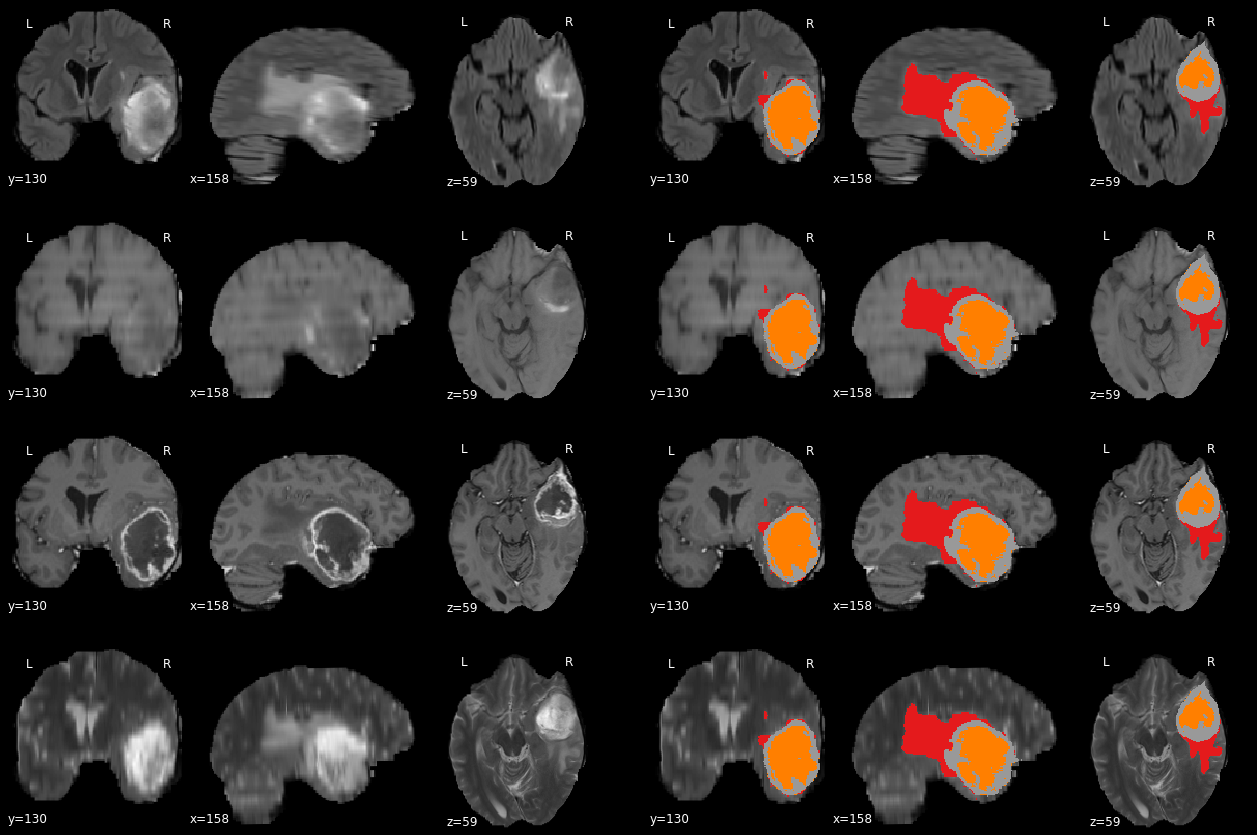

In [9]:
niis_by_channel = [image.index_img(nii, i) for i in range(nii.shape[-1])]

f, ax = plt.subplots(4,2, figsize=(18,12), facecolor=(0, 0, 0))
f.tight_layout()

for i in range(len(niis_by_channel)):
    plotting.plot_roi(seg, bg_img=niis_by_channel[i], figure=f, axes=ax[i][0], 
                      alpha = 0, dim=0, draw_cross = False
                     )
    plotting.plot_roi(seg, bg_img=niis_by_channel[i], figure=f, axes=ax[i][1], 
                      alpha = 1, cmap = 'Set1', dim=0, draw_cross = False
                     )
#f.savefig('./datasets/BRATS_001_fig.png', dpi=150, facecolor=(0, 0, 0))

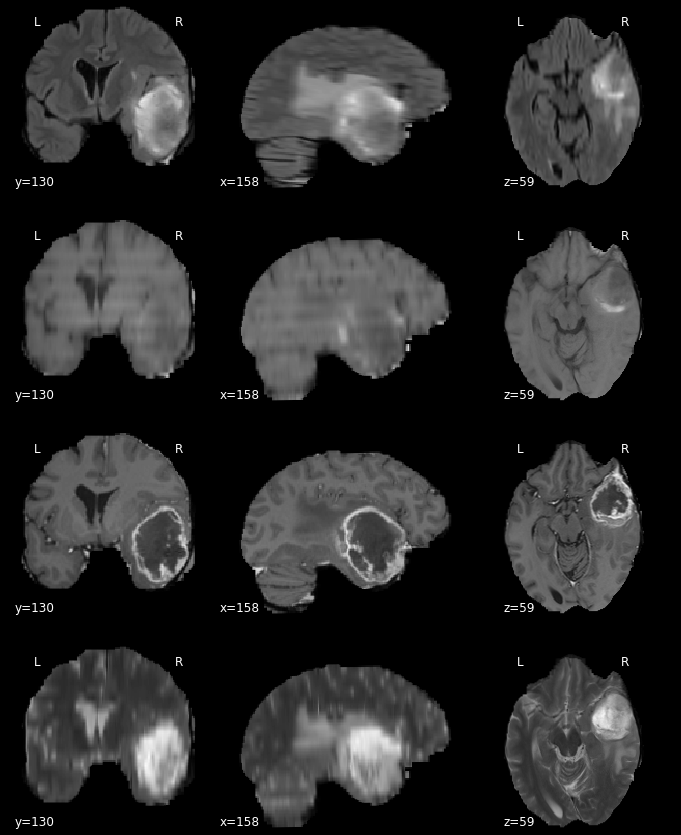

In [10]:
f, ax = plt.subplots(4,1, figsize=(10,12), facecolor=(0, 0, 0))
f.tight_layout()
for i in range(len(niis_by_channel)):
    plotting.plot_roi(seg, bg_img=niis_by_channel[i], figure=f, axes=ax[i], 
                      alpha = 0, dim=0, draw_cross = False
                     )
#f.savefig('./datasets/BRATS_001_fig_3.png', dpi=150, facecolor=(0, 0, 0))

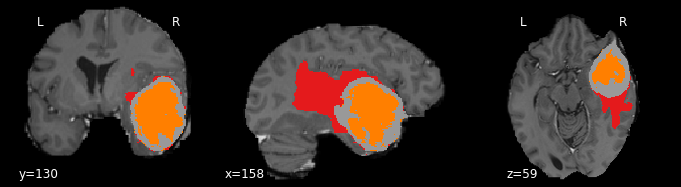

In [11]:
f, ax = plt.subplots(1,1, figsize=(10, 3), facecolor=(0, 0, 0))
f.tight_layout()
plotting.plot_roi(seg, bg_img=niis_by_channel[2], figure=f, axes=ax,
                  alpha = 1, cmap = 'Set1', dim=0, draw_cross = False
                 )
#f.savefig('./datasets/BRATS_001_fig_3_label.png', dpi=150, facecolor=(0, 0, 0))